#### Imports

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd

from utils import market_values, market_values_links, market_values_by_time_index, market_values_links_con, congestion_rent_link, convert_ISO_3166_2_to_1

# general variables
font1 = {'fontname':'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

In [2]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
carriers_buses = n.buses.carrier.unique().tolist()
carriers_gens = n.generators.carrier.unique().tolist()
carriers_links = n.links.carrier.unique().tolist()
carriers_buses
carriers_gens
carriers_links

['DC',
 'OCGT',
 'H2 Electrolysis',
 'H2 Fuel Cell',
 'battery charger',
 'battery discharger',
 'Sabatier',
 'SMR CC',
 'SMR',
 'BEV charger',
 'V2G',
 'residential rural ground heat pump',
 'residential rural water tanks charger',
 'residential rural water tanks discharger',
 'residential rural resistive heater',
 'residential rural gas boiler',
 'services rural ground heat pump',
 'services rural water tanks charger',
 'services rural water tanks discharger',
 'services rural resistive heater',
 'services rural gas boiler',
 'residential urban decentral air heat pump',
 'residential urban decentral water tanks charger',
 'residential urban decentral water tanks discharger',
 'residential urban decentral resistive heater',
 'residential urban decentral gas boiler',
 'services urban decentral air heat pump',
 'services urban decentral water tanks charger',
 'services urban decentral water tanks discharger',
 'services urban decentral resistive heater',
 'services urban decentral gas b

In [4]:
# sort carriers by similar technology / underlying energy for better investigation
car_bus_el = ['AC','battery','Li ion','low voltage','home battery' ]
car_bus_heat = ['residential rural heat', 'services rural heat','residential urban decentral heat', 'services urban decentral heat', 'urban central heat']
car_bus_bio_gas = ['H2','biogas','solid biomass','solid biomass for industry','gas for industry','H2 liquid']

car_gen_vre = ['offwind-ac', 'offwind-dc','onwind', 'solar', 'ror', 'solar rooftop']
car_gen_soltherm = [ 'residential rural solar thermal', 'services rural solar thermal', 'residential urban decentral solar thermal', 'services urban decentral solar thermal','urban central solar thermal',]

car_link_imp1 = ['OCGT', 'H2 Electrolysis', 'H2 Fuel Cell', 'Sabatier', 'SMR', "Fischer-Tropsch", "urban central gas CHP", "battery charger", "battery discharger"]
car_link_imp2 = ["OCGT", "H2 Electrolysis", "Fischer-Tropsch","Sabatier", "H2 Fuel Cell", "urban central gas CHP", "urban central gas CHP CC", "battery charger", "battery discharger", "home battery charger", "home battery discharger"   ]
car_link_mix = ['OCGT', 'H2 Electrolysis', 'H2 Fuel Cell', 'Sabatier', 'SMR', "Fischer-Tropsch", "urban central gas CHP", "battery charger", "battery discharger", "residential rural resistive heater","residential rural ground heat pump","residential rural gas boiler"]
car_link_resisitve_heater = ["residential rural resistive heater", "services rural resistive heater", "residential urban decentral resistive heater", "services urban decentral resistive heater", "urban central resistive heater" ]
car_link_heat_pumps = ["residential rural ground heat pump", "services rural ground heat pump", "residential urban decentral air heat pump", "services urban decentral air heat pump", "urban central air heat pump"  ]
car_link_gas_boiler = ["residential rural gas boiler", "services rural gas boiler", "residential urban decentral gas boiler", "services urban decentral gas boiler", "urban central gas boiler"]

#### General Investigation

In [5]:
# counts of number of regions where a generator of e specific carrier is present
n.generators.carrier.value_counts()

onwind                                       181
residential rural solar thermal              181
services rural solar thermal                 181
residential urban decentral solar thermal    181
services urban decentral solar thermal       181
urban central solar thermal                  181
solar                                        178
solar rooftop                                178
offwind-ac                                   100
ror                                           94
offwind-dc                                    69
gas                                            1
oil                                            1
Name: carrier, dtype: int64

In [6]:
mv_carriers = pd.DataFrame(index = n.buses.location.unique(), columns = carriers_gens)

for carrier in carriers_gens:
    mv_carriers[carrier] = market_values(n, carrier)

mv_carriers

offwind-ac      onwind      solar         ror  offwind-dc        gas  \
AL0 0  126.148417  131.075254  44.628736         NaN         NaN        NaN   
AT0 0         NaN   83.457109  54.679083   87.946522         NaN        NaN   
AT0 1         NaN   84.612302  65.745903   97.282183         NaN        NaN   
AT0 2         NaN   90.012931  58.223787   85.291980         NaN        NaN   
BA0 0         NaN  119.715551  51.160537         NaN         NaN        NaN   
...           ...         ...        ...         ...         ...        ...   
SE3 6   60.483666   53.277864  58.963028   77.032750   60.000468        NaN   
SE3 7   59.877949   63.297661  60.256194   66.164361   60.578980        NaN   
SI0 0  148.386481  125.246390  60.556211  111.663140         NaN        NaN   
SK0 0         NaN   91.144751  54.957441   93.823663         NaN        NaN   
EU            NaN         NaN        NaN         NaN         NaN  20.109146   

       residential rural solar thermal  services rural solar thermal  \
AL0 0                        28.100521                     28.138751   
AT0 0                        25.297088                     25.674329   
AT0 1                        48.136420                     48.114128   
AT0 2                        36.920372                     36.785644   
BA0 0                        27.930405                     26.504637   
...                                ...                           ...   
SE3 6                        36.445496                     36.991150   
SE3 7                        28.425435                     27.717632   
SI0 0                        28.066113                     26.536094   
SK0 0                        21.491470                     22.449092   
EU                                 NaN                           NaN   

       residential urban decentral solar thermal  \
AL0 0                                  36.469361   
AT0 0                                  34.858212   
AT0 1                                  57.898941   
AT0 2                                  50.714563   
BA0 0                                  37.326041   
...                                          ...   
SE3 6                                  42.670140   
SE3 7                                   6.907004   
SI0 0                                  36.636030   
SK0 0                                  29.961099   
EU                                           NaN   

       services urban decentral solar thermal  urban central solar thermal  \
AL0 0                               35.507220                    45.096866   
AT0 0                               34.521443                    39.641186   
AT0 1                               58.635892                    38.246840   
AT0 2                               49.973918                    40.517487   
BA0 0                               36.184464                    33.059630   
...                                       ...                          ...   
SE3 6                               41.596612                    38.443884   
SE3 7                               20.114828                    35.763463   
SI0 0                               35.702336                    39.247357   
SK0 0                               28.937610                    34.316675   
EU                                        NaN                          NaN   

             oil  solar rooftop  
AL0 0        NaN      56.499070  
AT0 0        NaN      64.462333  
AT0 1        NaN      77.031453  
AT0 2        NaN      69.284880  
BA0 0        NaN      58.363750  
...          ...            ...  
SE3 6        NaN      68.822199  
SE3 7        NaN      63.005445  
SI0 0        NaN      62.729094  
SK0 0        NaN      61.104808  
EU     50.009981            NaN  

[182 rows x 13 columns]

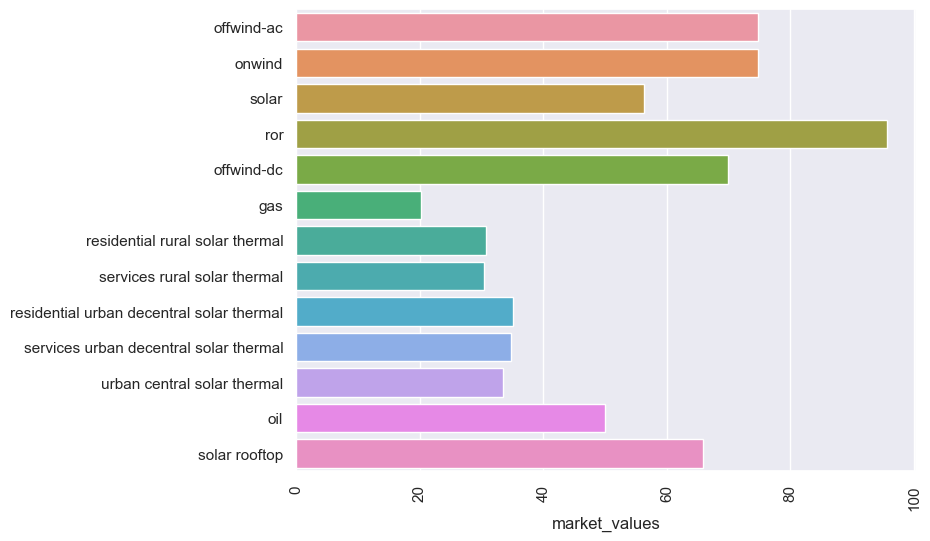

In [7]:
# plot overall market value for all carriers
mv_carriers_mean = pd.DataFrame(mv_carriers.mean())
mv_carriers_mean.columns = ["market_values"]
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data=mv_carriers_mean,y=mv_carriers_mean.index, x="market_values", orient="h")
ticks = plt.xticks(rotation=90)

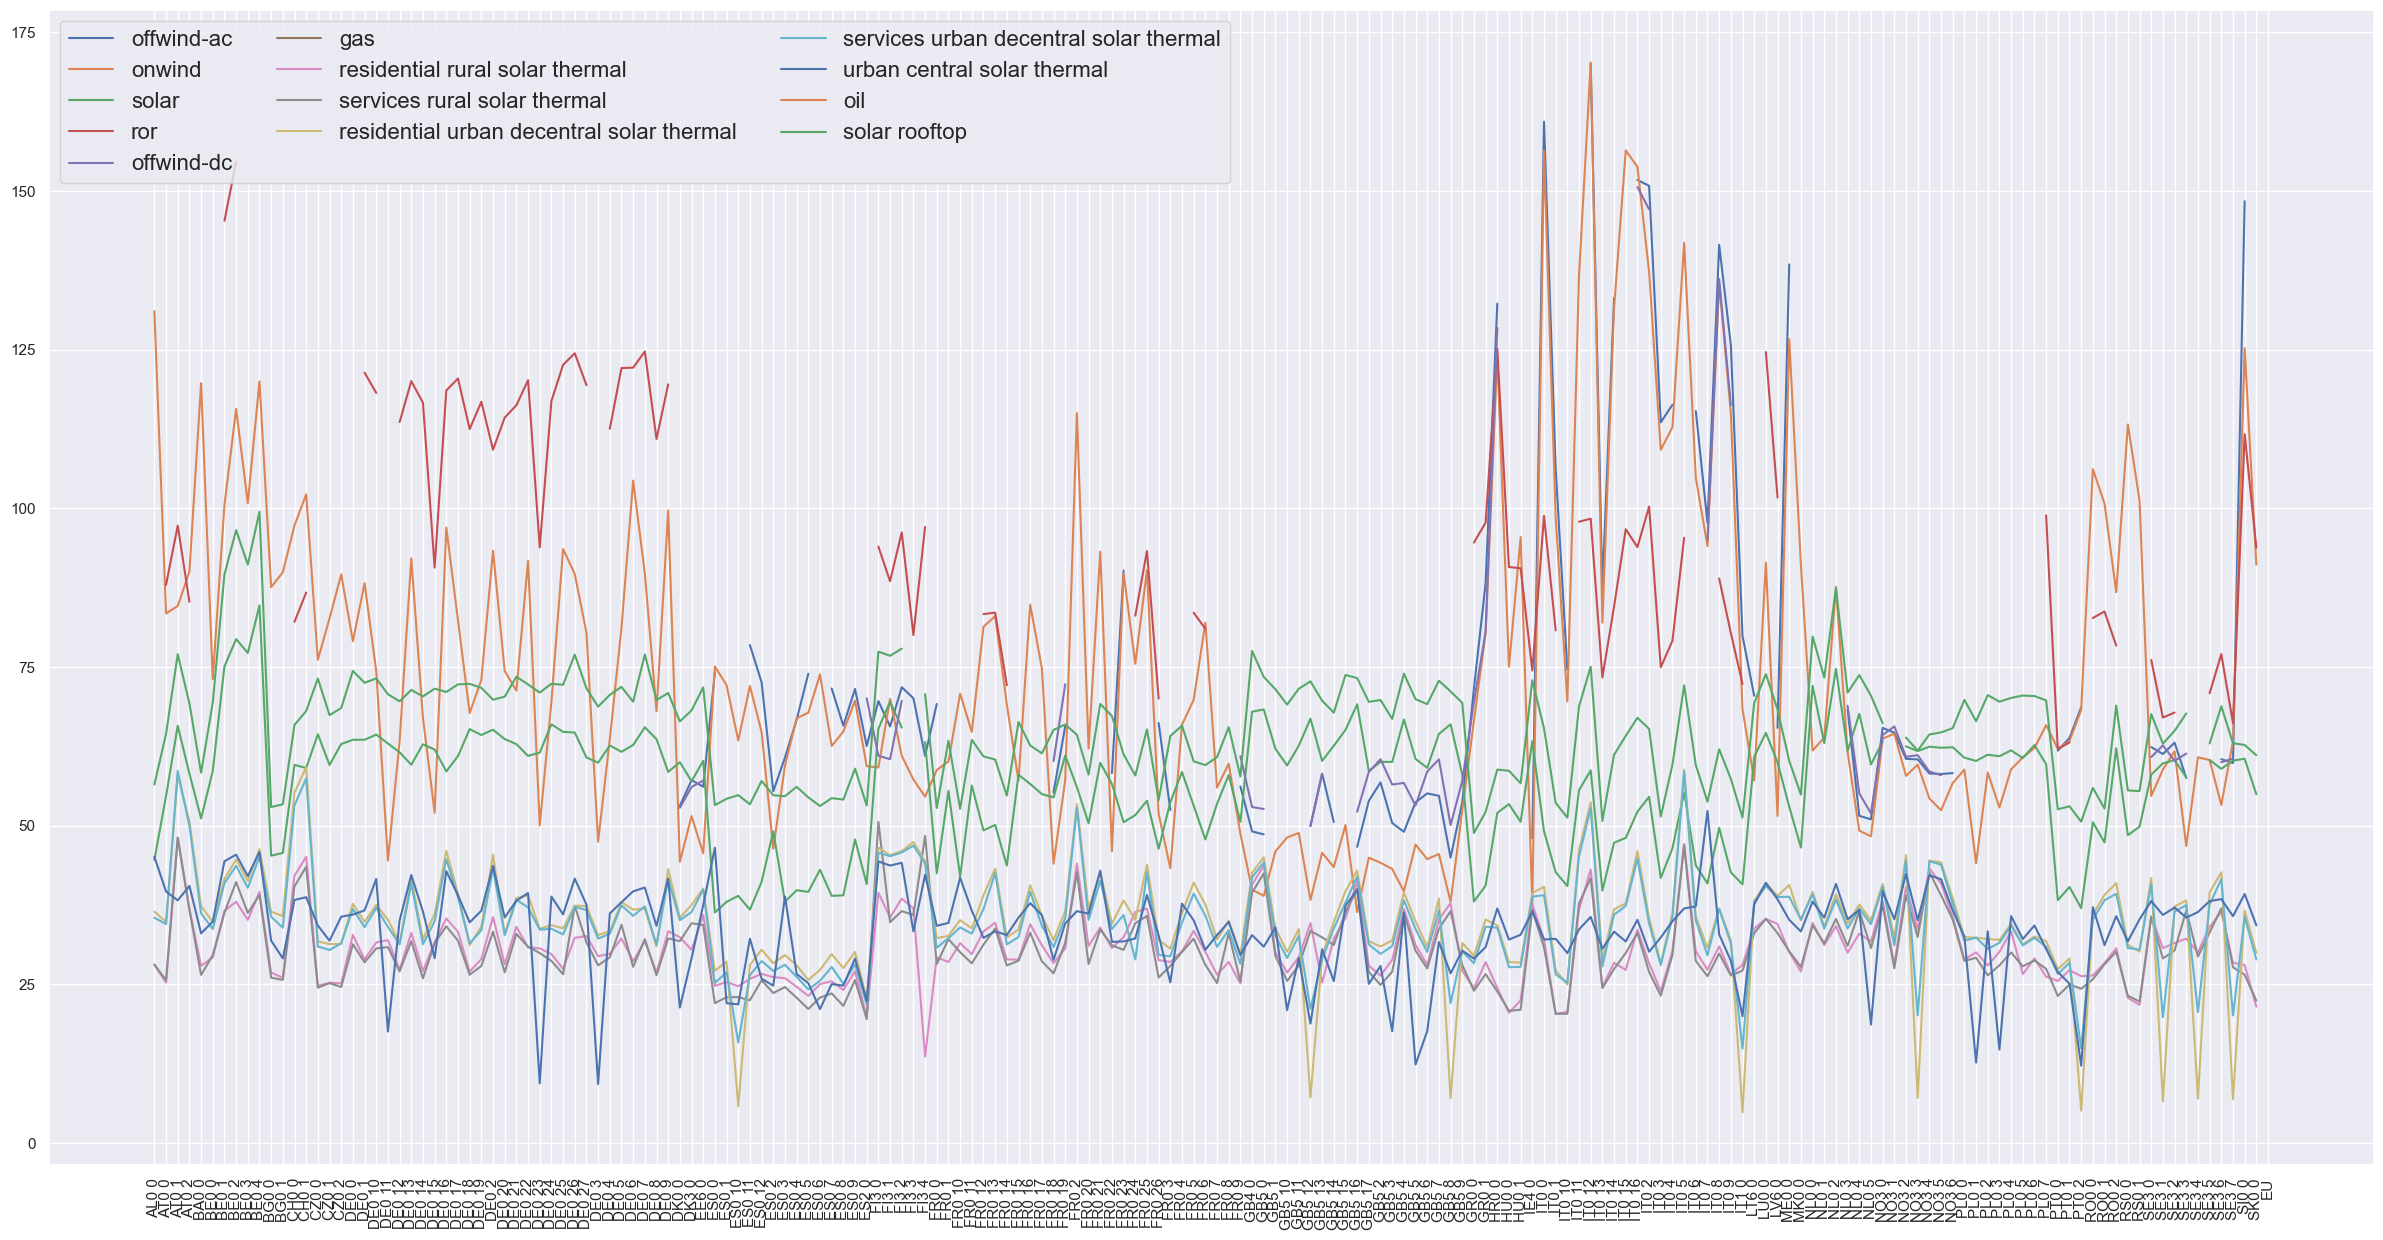

In [8]:
# market value of all carriers for all 181 regions
ax = mv_carriers.plot(figsize=(30,15))
plt.legend(loc='upper left', ncol=3, prop={'size': 16})
ax.set_xticks(range(len(mv_carriers)))
ticks = ax.set_xticklabels(labels = [item for item in mv_carriers.index.tolist()], rotation=90)

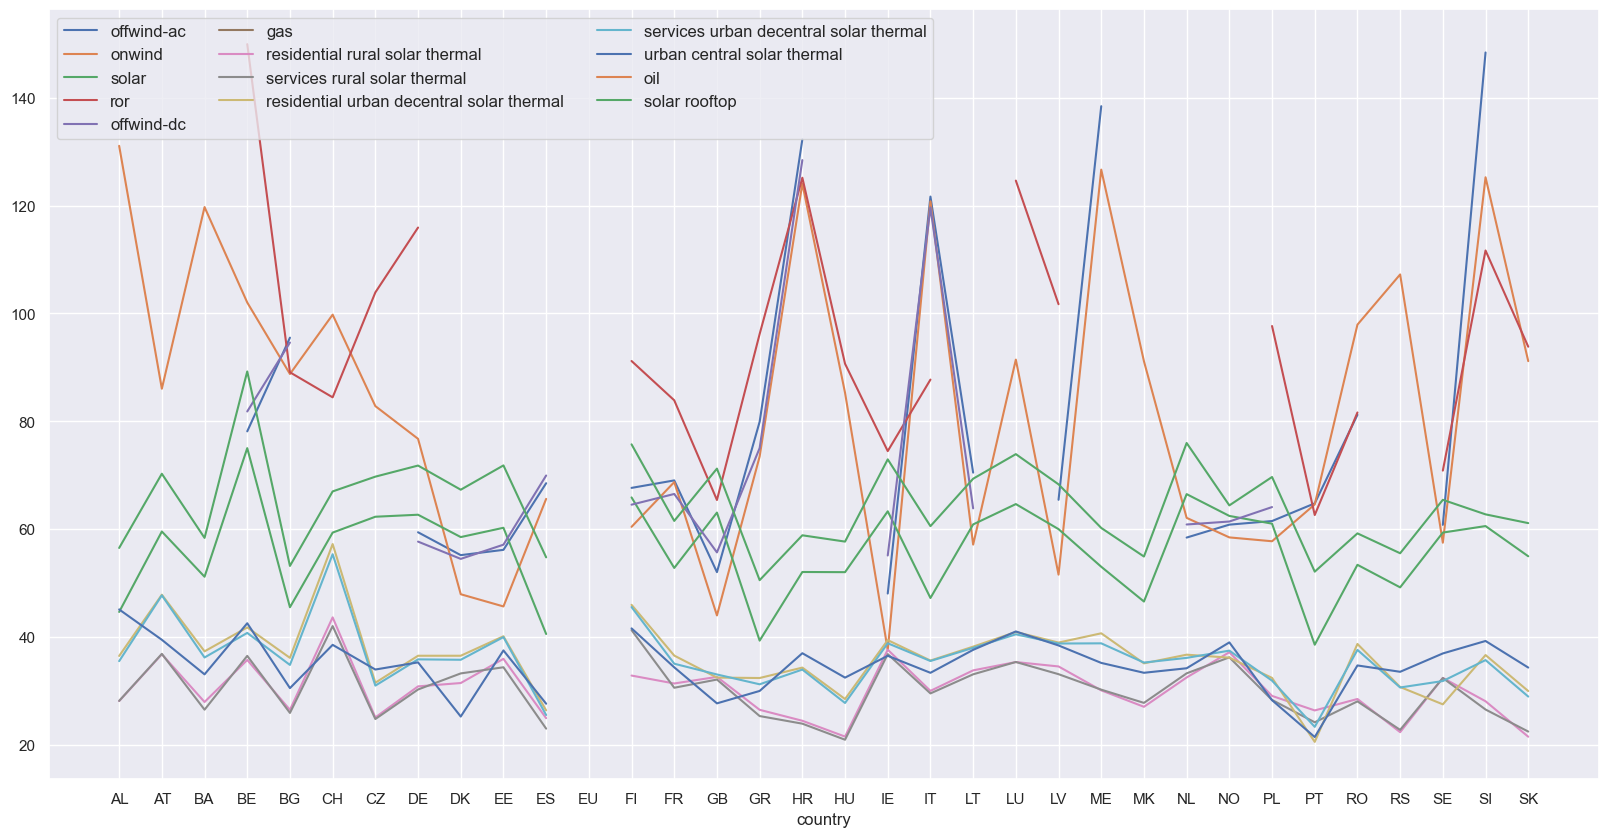

In [9]:
# Plot of mv of carriers by country
mv_carriers["country"] = mv_carriers.index.str[:2]
ax = mv_carriers.groupby(by="country").mean().plot(figsize=(20,10))
plt.legend(loc='upper left', ncol=3, prop={'size': 12})
ax.set_xticks(range(len(mv_carriers.groupby(by="country").mean())))
ticks = ax.set_xticklabels(labels = [item for item in mv_carriers.groupby(by="country").mean().index.tolist()], rotation=0)

In [10]:
# # Plot of market values of carriers for periods
days = pd.DatetimeIndex(np.unique(n.generators_t.p.index.date))
# plt.figure(figsize=(15, 10))
#
# for carrier in car_gen_vre:
#     mv = market_values_by_time_index(n, days, carrier)
#     plt.plot(mv.mean(axis=1), label=carrier)
#
# plt.legend()

In [11]:
# # Plot of all locational marginal prices over all carriers per regions
lmp_regions = n.buses_t.marginal_price.loc[:, n.buses.location.unique()[:-1]]
# df1 = lmp_regions.mean()
# sns.set(rc={'figure.figsize':(10,30)})
# ax = sns.barplot(y=df1.index, x=df1.values)
#
# for i in ax.containers:
#     ax.bar_label(i,)

In [12]:
# # Plot of lmp over all carriers averaged over countries
# df2 = lmp_regions.transpose()
# df2["country"] = df2.index.str[:2]
# df2 = df2.groupby(by="country").mean().mean(axis=1)
# sns.set(rc={'figure.figsize':(10,7)})
# ax = sns.barplot(y=df2.index, x=df2.values)
#
# for i in ax.containers:
#     ax.bar_label(i,)

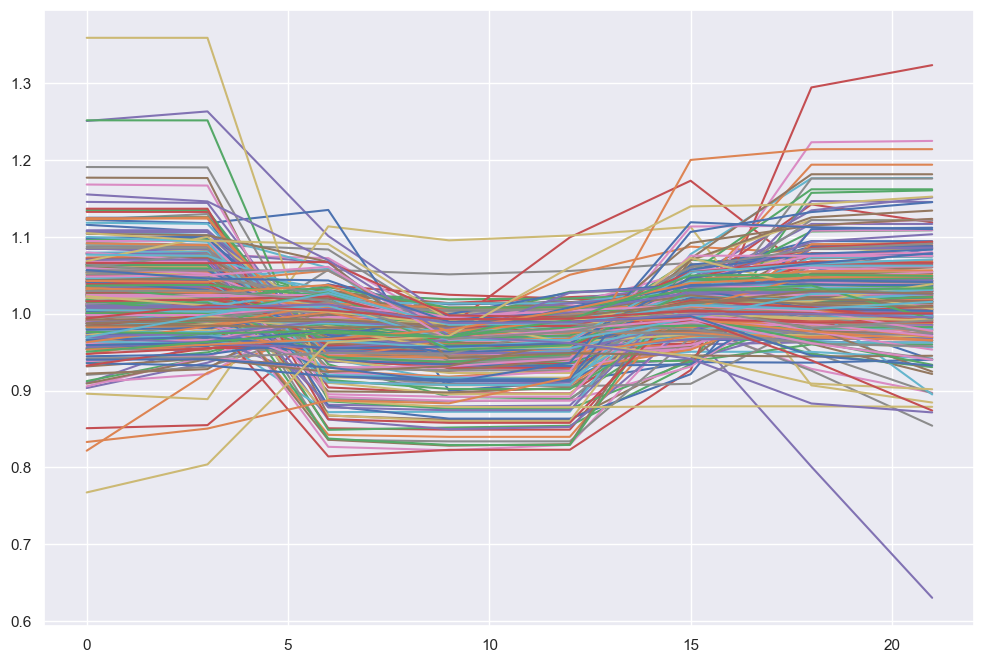

In [117]:
# Plot of lmp daily pattern of lmps over all carriers normalized by the mean price of the day
plt.figure(figsize=(12, 8))

carrier_bus = "H2" #carriers_buses
locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index]

for day in days:
    df = lmps[lmps.index.date == day.date()].mean(axis=1)
    df_normalized = df / df.mean()
    plt.plot(df_normalized.index.hour, df_normalized.values)

<AxesSubplot: xlabel='hour_of_day', ylabel='lmp_normalized'>

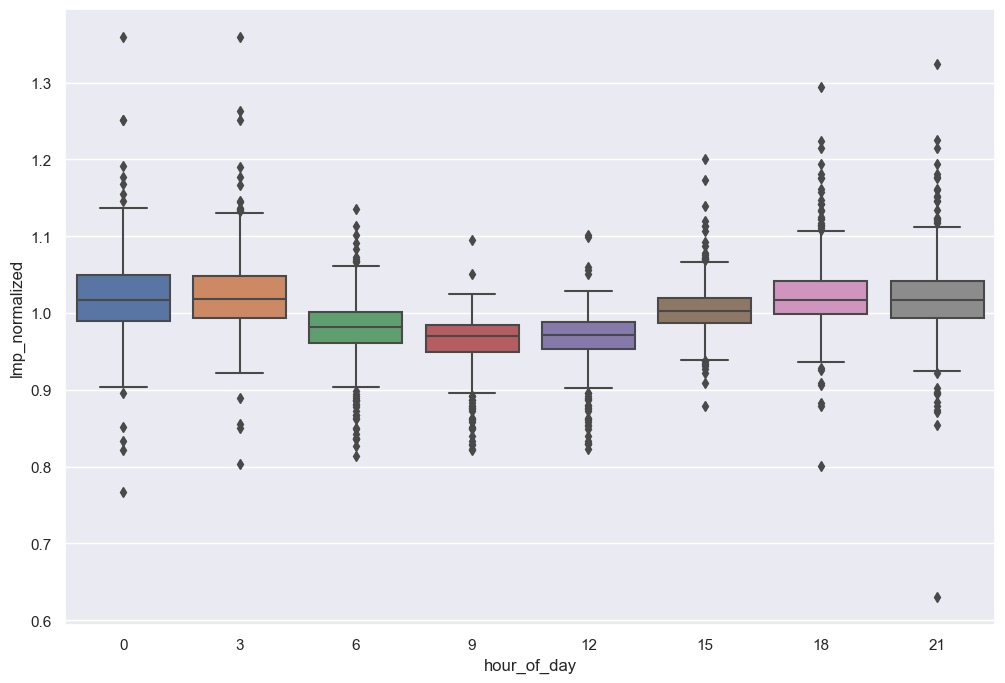

In [118]:
# # Plot of lmp daily pattern of lmps over all carriers normalized by the mean price of the current day
plt.figure(figsize=(12, 8))
df3 = pd.DataFrame(lmps.mean(axis=1))
df3.columns = ["lmp"]
df3["lmp_normalized"] = np.nan

for snap in df3.index:
    df3.loc[snap, "lmp_normalized"] = df3.loc[snap, "lmp"] / df3[df3.index.date == snap.date()].lmp.mean()

df3["hour_of_day"] = df3.index.hour
sns.boxplot(data=df3, y="lmp_normalized", x="hour_of_day")

### Regional distribution of market values per technology

#### Regions

In [15]:
onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

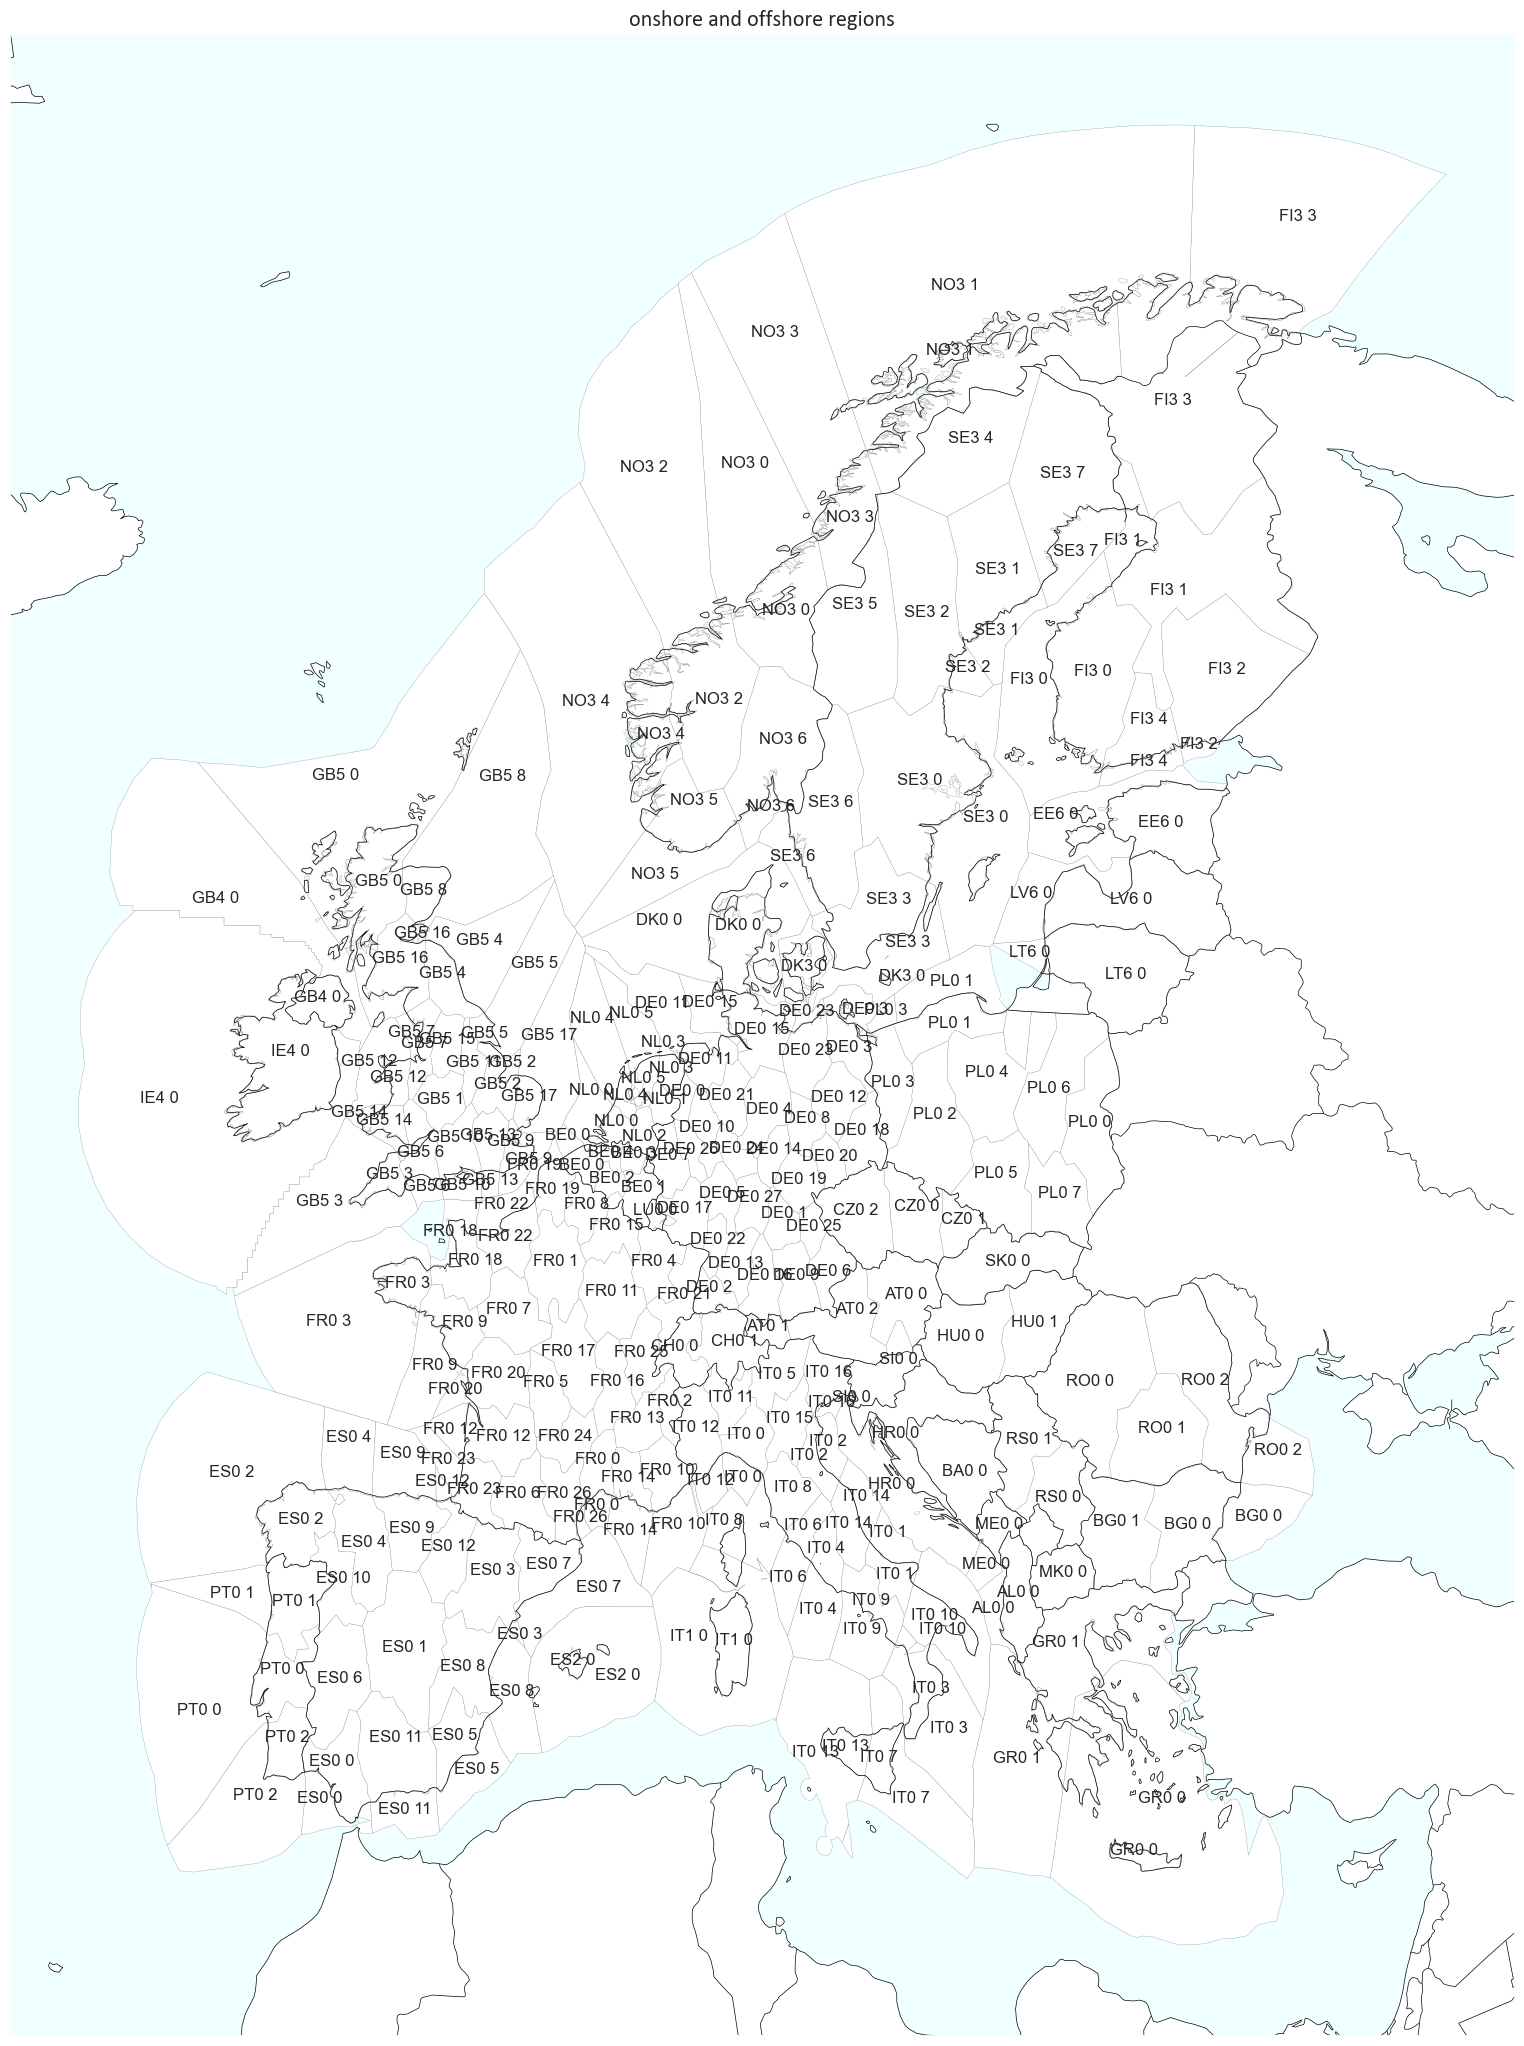

In [16]:
fig = plt.figure(figsize=(32, 26))

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title("onshore and offshore regions", fontsize=16, **font1)

onshore_regions.plot(ax=ax,
                     transform=ccrs.PlateCarree(),
                     linewidth=0.2,
                     facecolor="white",
                     edgecolor = 'grey')

offshore_regions.plot(ax=ax,
                     transform=ccrs.PlateCarree(),
                     linewidth=0.2,
                     facecolor="white",
                     edgecolor = 'grey')

for idx, row in onshore_regions.iterrows():
    plt.annotate(text=row['name'], xy=row['coords'],
                 horizontalalignment='center')

for idx, row in offshore_regions.iterrows():
    plt.annotate(text=row['name'], xy=row['coords'],
                 horizontalalignment='center')

plt.show()
# plt.close()

In [17]:
# fig.savefig(f"{PLOT_DIR}01_general/regions.png")

#### Market value per region

In [18]:
# function for carriers in n.generators.carrier.unique() #13
mv_regions_onshore = onshore_regions.copy()
mv_regions_offshore = offshore_regions.copy()

for carrier in n.generators.carrier.unique():
    mv_regions_onshore[carrier] = market_values(n, carrier)
    mv_regions_offshore[carrier] = market_values(n, carrier)

# mv_regions_onshore.to_crs(4326)
# mv_regions_onshore.crs
mv_regions_offshore.head(3)

geometry  \
name                                                       
AL0 0  POLYGON ((19.98542 39.69475, 20.01003 39.69120...   
BE0 0  POLYGON ((3.25367 51.34858, 3.10403 51.31485, ...   
BG0 0  POLYGON ((29.34583 42.24111, 28.32389 41.99778...   

                                        coords   name  offwind-ac      onwind  \
name                                                                            
AL0 0  (19.04227857401803, 40.790848115835146)  AL0 0  126.148417  131.075254   
BE0 0          (2.728512798889029, 51.5008335)  BE0 0   78.122119   73.103671   
BG0 0   (29.28183834594244, 42.87333189200004)  BG0 0   95.498412   87.582734   

           solar        ror  offwind-dc  gas  residential rural solar thermal  \
name                                                                            
AL0 0  44.628736        NaN         NaN  NaN                        28.100521   
BE0 0  58.613241        NaN   81.809493  NaN                        29.260113   
BG0 0  45.281165  89.073902   94.596314  NaN                        26.863697   

       services rural solar thermal  \
name                                  
AL0 0                     28.138751   
BE0 0                     29.615834   
BG0 0                     26.077307   

       residential urban decentral solar thermal  \
name                                               
AL0 0                                  36.469361   
BE0 0                                  34.840251   
BG0 0                                  36.446881   

       services urban decentral solar thermal  urban central solar thermal  \
name                                                                         
AL0 0                               35.507220                    45.096866   
BE0 0                               33.749229                    34.889495   
BG0 0                               35.670798                    31.907542   

       oil  solar rooftop  
name                       
AL0 0  NaN      56.499070  
BE0 0  NaN      69.372367  
BG0 0  NaN      52.951120

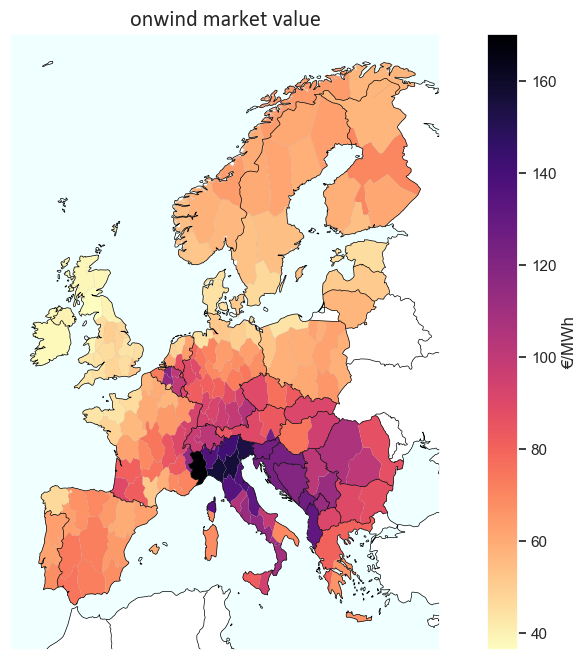

In [19]:
carrier = "onwind"

fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"{carrier} market value", fontsize=16, **font1)

mv_regions_onshore.plot(column=carrier,
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€/MWh",
                        'orientation': "vertical"})

plt.show()

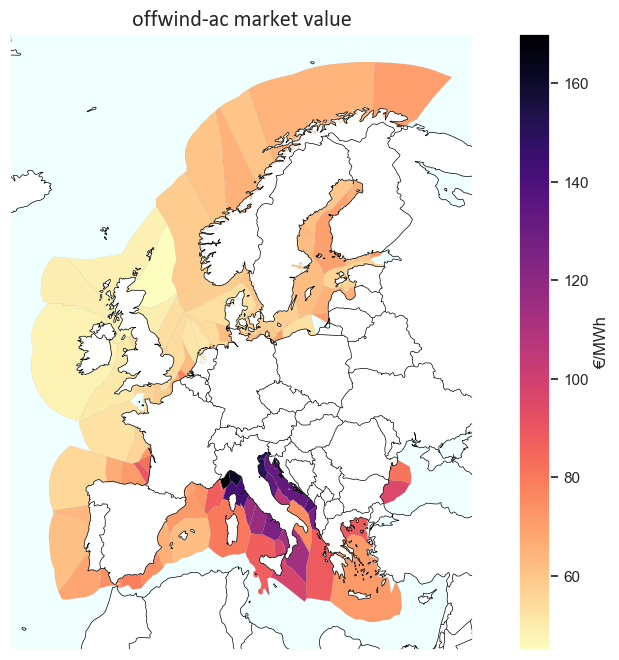

In [20]:
carrier = "offwind-ac"

fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"{carrier} market value", fontsize=16, **font1)

mv_regions_offshore.plot(column=carrier,
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€/MWh",
                        'orientation': "vertical"})

plt.show()

In [21]:
# fig.savefig('test.png')

In [121]:
n.links.carrier.unique()

array(['DC', 'OCGT', 'H2 Electrolysis', 'H2 Fuel Cell', 'battery charger',
       'battery discharger', 'Sabatier', 'SMR CC', 'SMR', 'BEV charger',
       'V2G', 'residential rural ground heat pump',
       'residential rural water tanks charger',
       'residential rural water tanks discharger',
       'residential rural resistive heater',
       'residential rural gas boiler', 'services rural ground heat pump',
       'services rural water tanks charger',
       'services rural water tanks discharger',
       'services rural resistive heater', 'services rural gas boiler',
       'residential urban decentral air heat pump',
       'residential urban decentral water tanks charger',
       'residential urban decentral water tanks discharger',
       'residential urban decentral resistive heater',
       'residential urban decentral gas boiler',
       'services urban decentral air heat pump',
       'services urban decentral water tanks charger',
       'services urban decentral water 

In [126]:
# function for carriers in n.links.carrier.unique() #53
mv_regions_onshore_links = onshore_regions.copy()

for carrier in n.links.carrier.unique():
    mv_regions_onshore_links[carrier] = market_values_links(n, carrier)

mv_regions_onshore_links.head(3)

geometry  \
name                                                       
AL0 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0  POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1  POLYGON ((10.08288 47.35907, 10.20928 47.37248...   

                                         coords   name  DC        OCGT  \
name                                                                     
AL0 0    (20.00648437943388, 41.14563914300007)  AL0 0 NaN  304.051963   
AT0 0  (15.700718667666258, 47.896990619088925)  AT0 0 NaN  312.461515   
AT0 1   (10.379200993764837, 47.18231496200006)  AT0 1 NaN  424.822735   

       H2 Electrolysis  H2 Fuel Cell  battery charger  battery discharger  \
name                                                                        
AL0 0        66.637006    120.601890        65.385803          106.129725   
AT0 0        82.512572    137.047324        76.587549          111.397523   
AT0 1        90.305267    140.326233        89.375799          130.615348   

       Sabatier  ...  gas for industry  gas for industry CC  H2 liquefaction  \
name             ...                                                           
AL0 0       NaN  ...               NaN                  NaN       137.617875   
AT0 0       NaN  ...               NaN                  NaN       151.448316   
AT0 1       NaN  ...               NaN                  NaN       154.026970   

       Fischer-Tropsch  process emissions  process emissions CC  DAC  \
name                                                                   
AL0 0              NaN                NaN                   NaN  NaN   
AT0 0              NaN                NaN                   NaN  NaN   
AT0 1              NaN                NaN                   NaN  NaN   

       electricity distribution grid  home battery charger  \
name                                                         
AL0 0                     118.132568             78.253283   
AT0 0                     117.569587             92.118676   
AT0 1                     125.877730             98.323916   

       home battery discharger  
name                            
AL0 0                86.106855  
AT0 0               100.313215  
AT0 1               106.597094  

[3 rows x 56 columns]

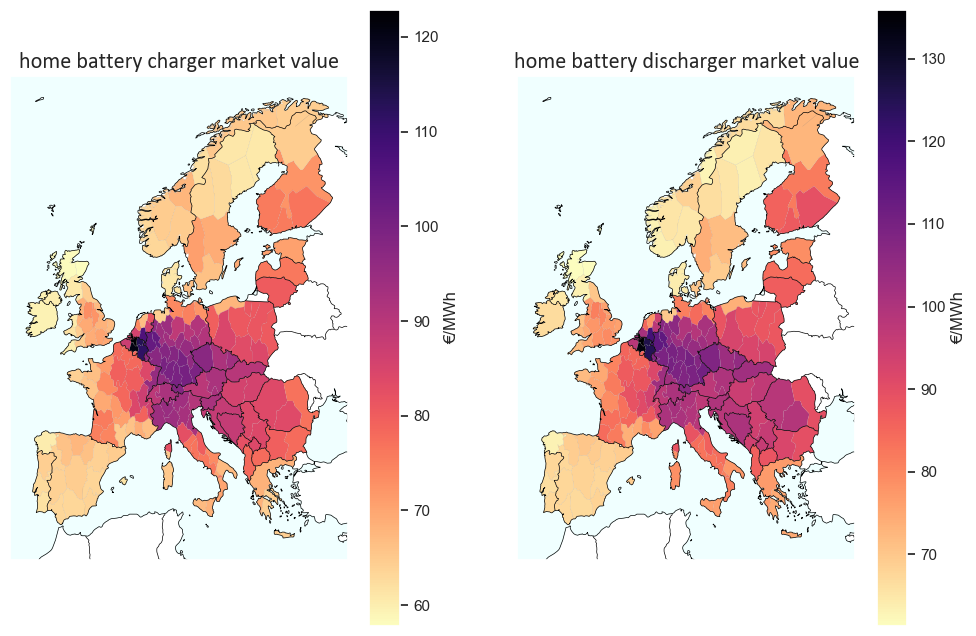

In [176]:
# compare two carriers
carriers=["home battery charger", "home battery discharger"]
# "battery discharger" # "battery charger" # "H2 Fuel Cell" #"Fischer-Tropsch" #"OCGT" #H2 Electrolysis" # H2 Electrolysis, H2 Fuel Cell

fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12, 8))

for i, ax in enumerate(axs):
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')
    ax.set_title(f"{carriers[i]} market value", fontsize=16, **font1)

    mv_regions_onshore_links.plot(column=carriers[i],
                         ax=ax,
                         transform=ccrs.PlateCarree(),
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'label':"€/MWh",
                            'orientation': "vertical"})
plt.show()

# TODO: Plot production amounts into regions as numbers or in another plot next to it

In [185]:
# most expensive regions
mv_regions_onshore_links[carriers[0]].sort_values(ascending=False)

name
BE0 4    122.846782
BE0 2    120.623736
BE0 3    113.067268
BE0 1    111.560127
NL0 2    106.770536
            ...    
GB4 0     59.912342
GB5 3     59.902746
IE4 0     59.578841
GB5 0     58.195435
GB5 8     57.804085
Name: home battery charger, Length: 181, dtype: float64

In [183]:
mv_regions_onshore_links[carriers[1]].sort_values(ascending=False)

name
BE0 4    135.921749
BE0 2    134.005524
BE0 3    125.805921
BE0 1    124.716177
NL0 2    119.265909
            ...    
NO3 4     63.284709
ES0 2     63.122394
NO3 3     62.812327
GB5 0     61.430642
GB5 8     61.291826
Name: home battery discharger, Length: 181, dtype: float64

__Findings__
- __H2 Electrolysis:__ no very clear pattern; highest values in BEL, NLD and NOR; Tendency of higher values on iberian peninsula, scandinavia and inner europe
- __H2 Fuel Cell:__ highest values for central europe (DEU, BEL,NLD)
- __OCGT:__ very high values in POL, LTU, LVA & DNK; high values in DEU, iberian peninsula, UK & south of sweden
- __battery charger:__ highest values in central europe (BEL, NLD, DEU, AUT); high prices in eastern europe; moderate prices in scandinavia; low prices on iberian peninsula
- __battery discharger:__ similar pattern as battery charger with higher values in FIN and scnadinavia beeing cheaper than iberain peninsula
- __home battery charger:__ similar pattern as battery charger with a slightly higher magnitude
- heat pumps (air-sourced/ground-sourced)
- __Fischer-Tropsch:__ Calculation unclear (bus1 is always EU with a constant oil lmp)
- Methanation (Sabatier)
- hydro/PHS/run-of-river
- wind (onshore/offshore)
- solar (utility/rooftop)
- battery charger (utility/home)
- battery discharger (utility/home)
- urban central gas CHP (CC)
- gas boiler
- resistive heater

#### DIff(LMP-MV) per region

In [25]:
carrier_bus = "H2"
mv = mv_regions_onshore_links["H2 Electrolysis"]
locs = n.buses.location[n.buses[n.buses.carrier == carrier].index]
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier].index].mean()
df = pd.concat([lmps, locs], axis=1).rename(columns={0: "lmp"})
lmp_regions_onshore = mv_regions_onshore[["geometry","coords","name"]].copy().rename(columns={"name": "location"})
lmp_regions_onshore = pd.merge(lmp_regions_onshore,df,on="location").set_index("location")
lmp_regions_onshore["diff"] = (lmp_regions_onshore["lmp"] - mv)

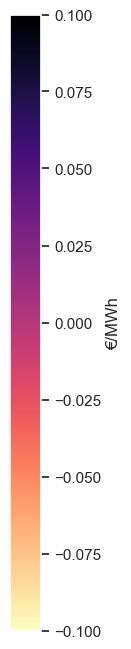

In [26]:
fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"{carrier} lmp", fontsize=16, **font1)

lmp_regions_onshore.plot(column="diff",
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€/MWh",
                        'orientation': "vertical"})

plt.show()

#### Market values per country

In [27]:
# geopandas country data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.drop(["pop_est","gdp_md_est"], axis=1)
# Remove French Guiana from France.
shape = world[world['name'] == 'France']['geometry'].all()
fr_df = pd.Series(['France', 'France'], name='country')
fr_df = gpd.GeoDataFrame(fr_df, geometry=[shape[1], shape[2]])
fr_df = fr_df.dissolve(by='country')
world.geometry[world['name'] == 'France'] = fr_df['geometry'].values
# Remove Svalbard
shape = world[world['name'] == 'Norway']['geometry'].all()
no_df = pd.Series(['Norway'], name='country')
no_df = gpd.GeoDataFrame(no_df, geometry=[shape[1]])
no_df = no_df.dissolve(by='country')
world.geometry[world['name'] == 'Norway'] = no_df['geometry'].values

In [28]:
# convert country codes and map
mv_country_onshore = mv_regions_onshore.drop(["geometry","coords"], axis=1)
mv_country_onshore["country"] = mv_country_onshore.index.str[:2]
mv_country_onshore = mv_country_onshore.groupby(by="country").mean()
mv_country_onshore["iso_a3"] = pd.Index([convert_ISO_3166_2_to_1[cc] for cc in mv_country_onshore.index])
mv_country_onshore=pd.merge(world, mv_country_onshore,on='iso_a3')

mv_country_onshore['coords'] = mv_country_onshore['geometry'].apply(lambda x: x.representative_point().coords[:])
mv_country_onshore['coords'] = [coords[0] for coords in mv_country_onshore['coords']]
mv_country_onshore

continent              name iso_a3  \
0     Europe            Norway    NOR   
1     Europe            France    FRA   
2     Europe            Sweden    SWE   
3     Europe            Poland    POL   
4     Europe           Austria    AUT   
5     Europe           Hungary    HUN   
6     Europe           Romania    ROU   
7     Europe         Lithuania    LTU   
8     Europe            Latvia    LVA   
9     Europe           Estonia    EST   
10    Europe           Germany    DEU   
11    Europe          Bulgaria    BGR   
12    Europe            Greece    GRC   
13    Europe           Albania    ALB   
14    Europe           Croatia    HRV   
15    Europe       Switzerland    CHE   
16    Europe        Luxembourg    LUX   
17    Europe           Belgium    BEL   
18    Europe       Netherlands    NLD   
19    Europe          Portugal    PRT   
20    Europe             Spain    ESP   
21    Europe           Ireland    IRL   
22    Europe             Italy    ITA   
23    Europe           Denmark    DNK   
24    Europe    United Kingdom    GBR   
25    Europe          Slovenia    SVN   
26    Europe           Finland    FIN   
27    Europe          Slovakia    SVK   
28    Europe           Czechia    CZE   
29    Europe  Bosnia and Herz.    BIH   
30    Europe   North Macedonia    MKD   
31    Europe            Serbia    SRB   
32    Europe        Montenegro    MNE   

                                             geometry  offwind-ac      onwind  \
0   POLYGON ((31.10104 69.55810, 29.39955 69.15692...   60.821353   58.454961   
1   MULTIPOLYGON (((9.39000 43.00998, 9.56002 42.1...   69.024474   68.713874   
2   POLYGON ((11.02737 58.85615, 11.46827 59.43239...   60.779603   57.474181   
3   POLYGON ((23.48413 53.91250, 23.52754 53.47012...   61.489763   57.741911   
4   POLYGON ((16.97967 48.12350, 16.90375 47.71487...         NaN   86.027448   
5   POLYGON ((22.08561 48.42226, 22.64082 48.15024...         NaN   85.272289   
6   POLYGON ((28.23355 45.48828, 28.67978 45.30403...   81.190049   97.911789   
7   POLYGON ((26.49433 55.61511, 26.58828 55.16718...   70.469416   57.117603   
8   POLYGON ((27.28818 57.47453, 27.77002 57.24426...   65.430620   51.552146   
9   POLYGON ((27.98113 59.47537, 27.98112 59.47537...   56.147002   45.651448   
10  POLYGON ((14.11969 53.75703, 14.35332 53.24817...   59.407815   76.736514   
11  POLYGON ((22.65715 44.23492, 22.94483 43.82379...   95.498412   88.758203   
12  MULTIPOLYGON (((26.29000 35.29999, 26.16500 35...   79.905399   73.456955   
13  POLYGON ((21.02004 40.84273, 20.99999 40.58000...  126.148417  131.075254   
14  POLYGON ((16.56481 46.50375, 16.88252 46.38063...  132.260889  124.068663   
15  POLYGON ((9.59423 47.52506, 9.63293 47.34760, ...         NaN   99.764625   
16  POLYGON ((6.04307 50.12805, 6.24275 49.90223, ...         NaN   91.428500   
17  POLYGON ((6.15666 50.80372, 6.04307 50.12805, ...   78.122119  102.018986   
18  POLYGON ((6.90514 53.48216, 7.09205 53.14404, ...   58.423510   62.081147   
19  POLYGON ((-9.03482 41.88057, -8.67195 42.13469...   64.771007   64.573713   
20  POLYGON ((-7.45373 37.09779, -7.53711 37.42890...   68.504326   65.599006   
21  POLYGON ((-6.19788 53.86757, -6.03299 53.15316...   48.046259   37.575800   
22  MULTIPOLYGON (((10.44270 46.89355, 11.04856 46...  121.661564  120.780284   
23  MULTIPOLYGON (((9.92191 54.98310, 9.28205 54.8...   55.165798   47.915832   
24  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...   52.014777   43.985978   
25  POLYGON ((13.80648 46.50931, 14.63247 46.43182...  148.386481  125.246390   
26  POLYGON ((28.59193 69.06478, 28.44594 68.36461...   67.637634   60.412897   
27  POLYGON ((22.55814 49.08574, 22.28084 48.82539...         NaN   91.144751   
28  POLYGON ((15.01700 51.10667, 15.49097 50.78473...         NaN   82.804580   
29  POLYGON ((18.56000 42.65000, 17.67492 43.02856...         NaN  119.715551   
30  POLYGON ((22.38053 42.32026, 22.88137 41.99930...         NaN   91.127396   
31  POLYGON ((18

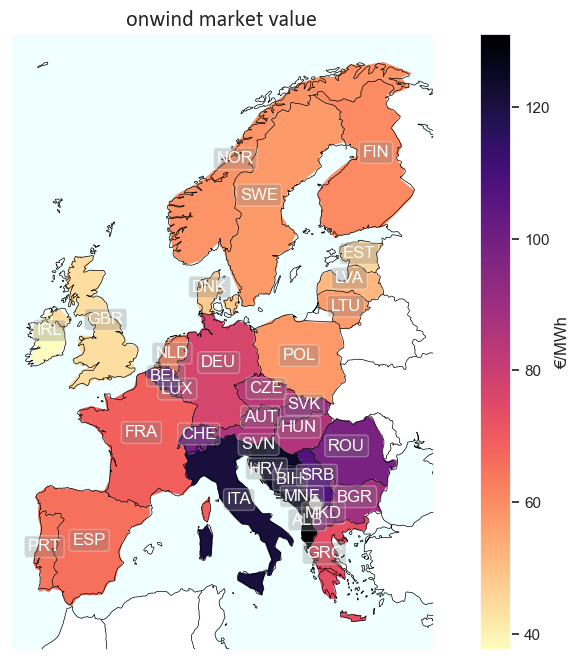

In [29]:
carrier = "onwind"

fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"{carrier} market value", fontsize=16, **font1)

mv_country_onshore.plot(column=carrier,
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€/MWh",
                        'orientation': "vertical"})

for idx, row in mv_country_onshore.iterrows():
    plt.annotate(text=row['iso_a3'], xy=row['coords'], color='white',
                 bbox=dict(boxstyle='round,pad=0.2', fc='grey', alpha=0.3),
                 horizontalalignment='center')

plt.show()

In [30]:
# carriers for which market_values function does not work
# -> there are 24 carrier which are not a generators but attached to a bus; from the generators only 2 are also attached to buses {'gas', 'oil'}
# all renewables are produced at generators and are not directly attached to a bus; the generator is attached to the bus (thats also why they do not have lmps)
# set(n.buses.carrier.tolist()) - set(n.generators.carrier.tolist()) # 24

### Spatial and temporal distribution of prices:

- electricity
- heat (various subcategories)
- hydrogen

#### Nodal Prices for every time step (sum) - heatmap

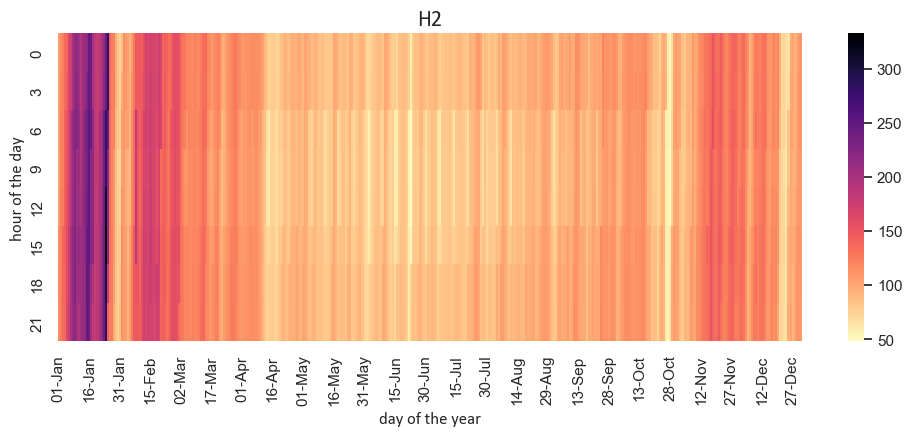

In [31]:
carrier = "H2" # H2, services rural heat, low voltage (no values for VRE as they do not have their own buses)
# change to mean for
df = pd.DataFrame(n.buses_t.marginal_price[n.buses[n.buses.carrier==carrier].index].mean(axis=1))

hours = df.index.hour.unique()
df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

for hour in hours:
    df_start[str(hour)] = df[df.index.hour==hour].values

plt.figure(figsize=(12, 4))
ax = sns.heatmap(df_start.transpose(),
                 cmap=plt.get_cmap("magma_r"),
                 linewidth=0.001,
                 xticklabels=15)
plt.title(str(carrier), fontsize=16, **font1)
plt.ylabel("hour of the day", fontsize=12, **font1)
plt.xlabel("day of the year", fontsize=12, **font1)

# Rewrite the y labels
x_labels = ax.get_xticks()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

plt.show()

### Time series analysis

- when do different technologies produce?
- when are their revenues created? (nodal price * production) (e.g. like
attached graphic)
- what are the prices when they produce?


#### Technology Operation and Revenue by Price band

In [32]:
# plot percentage of production per price band and percentage of revenue per price band
carriers_gen = ["onwind", "solar", "ror", "offwind-dc", "gas"]
carriers_link = ["H2 Electrolysis", "H2 Fuel Cell"]
carriers_labels = (carriers_gen + carriers_link)
price_bands = [0, 5, 50, 100, 200, 1000, np.inf]
price_bands_labels = ["0 - 5", "5 - 50", "50 - 100", "100 - 200", "200 - 1000", "> 1000"]
res_prod = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers_labels)
res_rev = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers_labels)

In [33]:
for carrier in carriers_gen:
    gen = n.generators_t.p.loc[:, n.generators.carrier == carrier]
    gen.columns = gen.columns.map(n.generators.bus)
    lmp = n.buses_t.marginal_price.loc[:, gen.columns]
    rev = gen * lmp

    for i in range(len(price_bands)-1):
        lmp_cat = lmp.mask((lmp >= price_bands[i]) & (lmp < price_bands[i+1]), "hit")
        res_prod.loc[str(i), carrier] = gen[lmp_cat == "hit"].sum().sum() / gen.sum().sum()
        res_rev.loc[str(i), carrier] = rev[lmp_cat == "hit"].sum().sum() / rev.sum().sum()

for carrier in carriers_link:
    # prices of the generated energy
    gen = abs(n.links_t.p1.loc[:, n.links.carrier == carrier])
    gen.columns = gen.columns.map(n.links.bus1)
    lmp = n.buses_t.marginal_price.loc[:, gen.columns]
    rev = gen * lmp

    for i in range(len(price_bands)-1):
        lmp_cat = lmp.mask((lmp >= price_bands[i]) & (lmp < price_bands[i+1]), "hit")
        res_prod.loc[str(i), carrier] = gen[lmp_cat == "hit"].sum().sum() / gen.sum().sum()
        res_rev.loc[str(i), carrier] = rev[lmp_cat == "hit"].sum().sum() / rev.sum().sum()

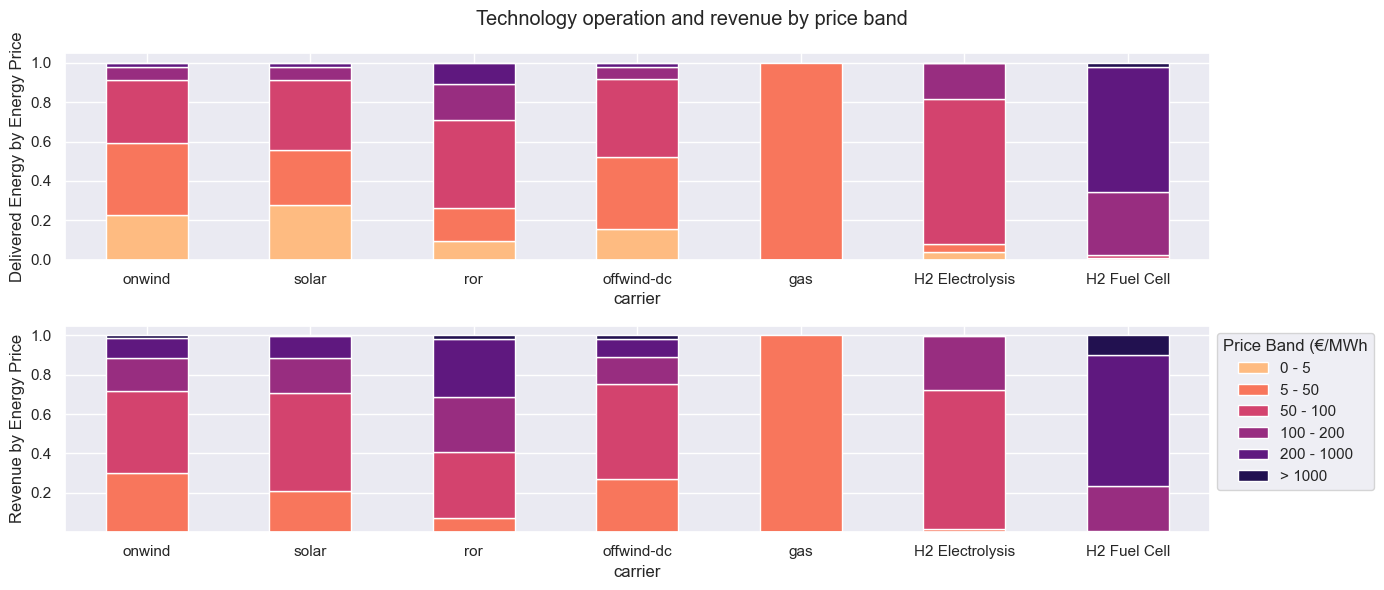

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

fig.suptitle('Technology operation and revenue by price band')

ax0 = res_prod.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 6), ax=axes[0], legend=False)
ax0.set_ylabel("Delivered Energy by Energy Price")
ax0.set_xlabel("carrier")
ax0.set_xticks(ticks=range(len(carriers_labels)), labels=carriers_labels, rotation=0)

ax1 = res_rev.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 6), ax=axes[1])
ax1.legend(title='Price Band (€/MWh', labels=price_bands_labels, bbox_to_anchor=(1, 1))
ax1.set_ylabel("Revenue by Energy Price")
ax1.set_xlabel("carrier")
ax1.set_xticks(ticks=range(len(carriers_labels)), labels=carriers_labels, rotation=0)

fig.tight_layout()

#### Energy conversion technologies production and revenue by input technology price band (links)

In [35]:
carriers = car_link_mix

res_prod2 = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers)
res_rev2 = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers)

In [36]:
for carrier in carriers:
# prices of the consumed energy
    con = n.links_t.p0.loc[:, n.links.carrier == carrier]
    transform_columns = n.links_t.p0.loc[:, n.links.carrier == carrier].columns.map(n.links.bus1)
    con.columns = con.columns.map(n.links.bus0)
    lmp_con = n.buses_t.marginal_price.loc[:, con.columns]
    cost = con * lmp_con

    gen = abs(n.links_t.p1.loc[:, n.links.carrier == carrier])
    gen.columns = gen.columns.map(n.links.bus1)
    lmp_gen = n.buses_t.marginal_price.loc[:, gen.columns]
    rev = gen * lmp_gen

    for i in range(len(price_bands)-1):
        lmp_cat1 = lmp_con.mask((lmp_con >= price_bands[i]) & (lmp_con < price_bands[i+1]), "hit")
        # pay attention to indices (if something went wrong then probably here)
        lmp_cat1.columns = transform_columns
        res_prod2.loc[str(i), carrier] = gen[lmp_cat1 == "hit"].sum().sum() / gen.sum().sum()
        res_rev2.loc[str(i), carrier] = rev[lmp_cat1 == "hit"].sum().sum() / rev.sum().sum()

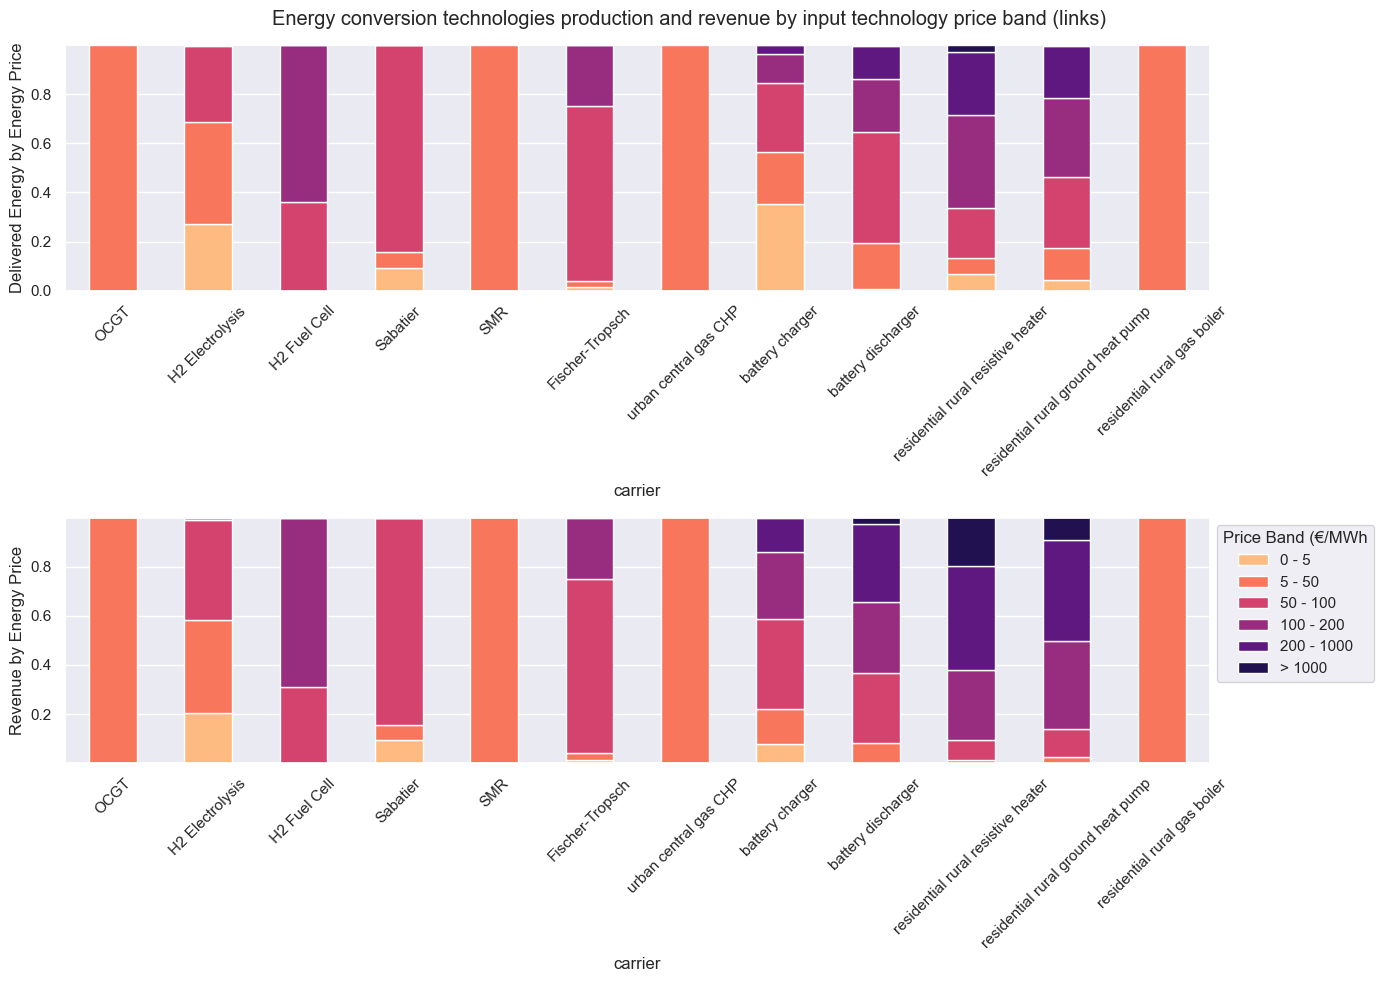

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

fig.suptitle('Energy conversion technologies production and revenue by input technology price band (links) ')

ax0 = res_prod2.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 6), ax=axes[0], legend=False)
ax0.set_ylabel("Delivered Energy by Energy Price")
ax0.set_xlabel("carrier")
ax0.set_xticks(ticks=range(len(carriers)), labels=carriers, rotation=45)

ax1 = res_rev2.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 6), ax=axes[1])
ax1.legend(title='Price Band (€/MWh', labels=price_bands_labels, bbox_to_anchor=(1, 1))
ax1.set_ylabel("Revenue by Energy Price")
ax1.set_xlabel("carrier")
ax1.set_xticks(ticks=range(len(carriers)), labels=carriers, rotation=45)

fig.tight_layout()

### Congestion rent
Additionally: Calculate congestion rents for link components: price difference i-j * flow i-j
ToDo: maybe also for line components?

In [43]:
carriers = carriers_links
cr_res1 = pd.DataFrame(index = range(1), columns=carriers)

for carrier in carriers:
    cr_res1[carrier] = congestion_rent_link(n,carrier).sum().sum()

In [69]:
cr_res1 = cr_res1.sort_values(by=0, axis='columns', ascending=False)

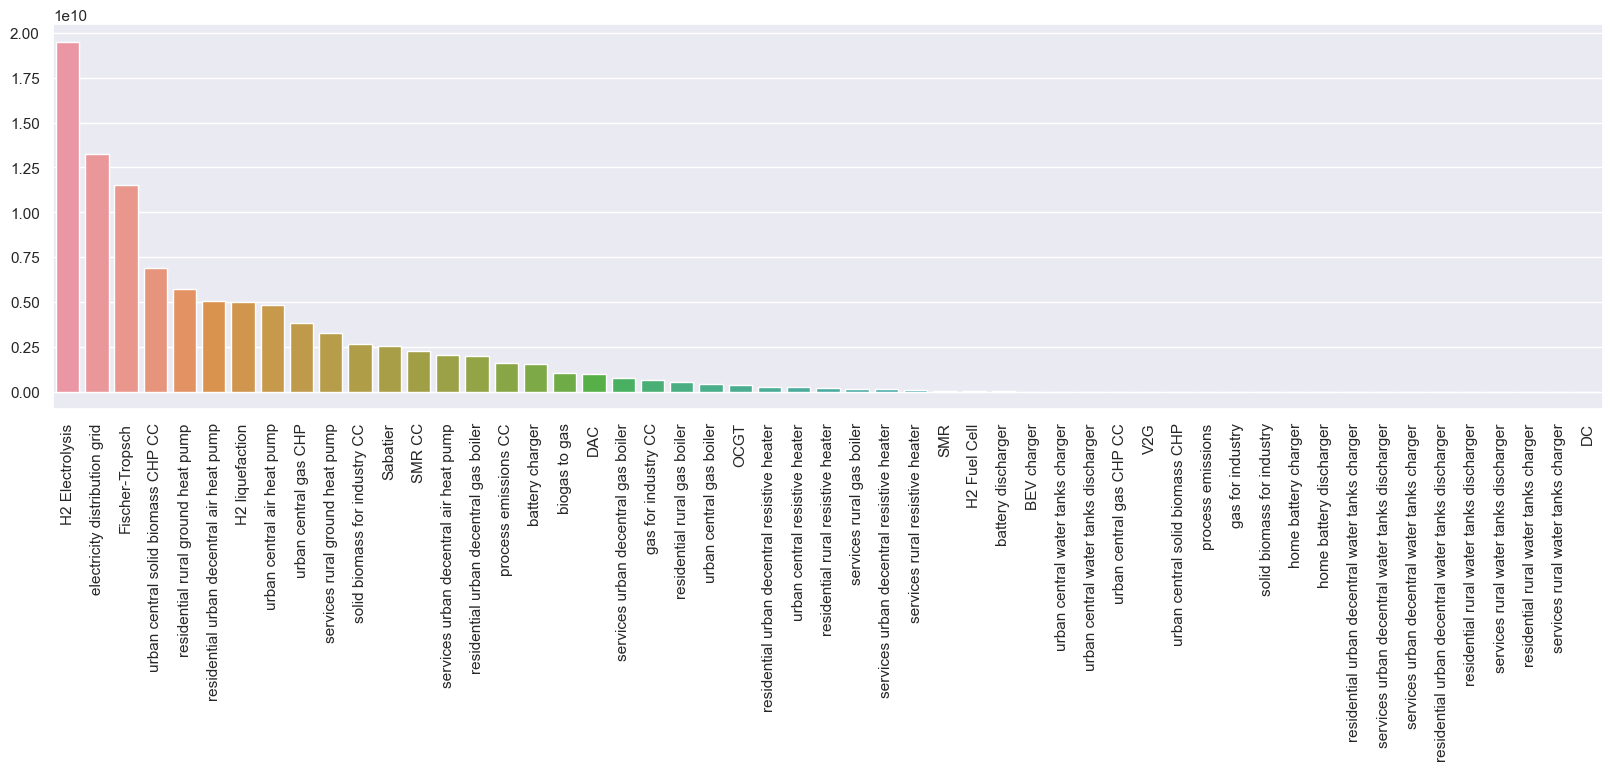

In [70]:
sns.set(rc={'figure.figsize':(20,5)})
sns.barplot(data=cr_res1)
ticks = plt.xticks(rotation=90)

__Findings__
- negative values for some technologies: OCGT, water tanks, battery charger but in much smaller magnitude than positive values (maybe due to numeric inaccuracy)

In [113]:
# Congestion rent by country
carrier = cr_res1.columns[0] #"OCGT" # "battery charger" #"OCGT" # "H2 Electrolysis"
cr_regions = congestion_rent_link(n,carrier).sum()

if n.buses.loc[cr_regions.index.map(n.links.bus0)].location.values[0] == 'EU':
    bus = "bus1"
else:
    bus = "bus0"

cr_regions = pd.concat([cr_regions,n.links.loc[cr_regions.index][bus]], axis=1).rename(columns={0: "cr"})
cr_regions["location"] = n.buses.loc[cr_regions.index.map(n.links[bus])].location.values
cr_regions.head(3)
# TODO: For plotting the cr into a map which bus should be used? bus0, where the energy comes from or bus1 where the energy goes to? For some carriers e.g. Fischer-Tropsch they are not in the same region (EU bus)

cr      bus0 location
Link                                                  
AL0 0 H2 liquefaction  1.891549e+06  AL0 0 H2    AL0 0
AT0 0 H2 liquefaction  1.354453e+06  AT0 0 H2    AT0 0
AT0 1 H2 liquefaction  1.631584e+05  AT0 1 H2    AT0 1

In [114]:
cr_regions_onshore = onshore_regions.copy().rename(columns={"name": "location"})
cr_regions_onshore = pd.merge(cr_regions_onshore, cr_regions, on="location")
# cr_regions_onshore.head()

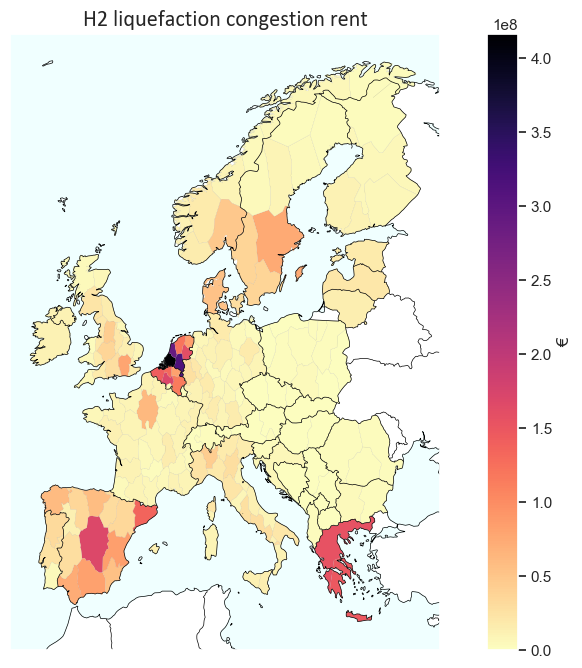

In [115]:
fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"{carrier} congestion rent", fontsize=16, **font1)

cr_regions_onshore.plot(column="cr",
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€",
                        'orientation': "vertical"})

plt.show()
# TODO: Would be interesting to plot a map with the location of the capacity of the corresponding carrier next to it; probably there is a correlation between higher capacity and higher cr

In [116]:
cr_regions_onshore.sort_values(by="cr", ascending=False)

geometry  \
142  MULTIPOLYGON (((4.18002 51.37743, 4.22149 51.3...   
144  POLYGON ((6.19355 51.34452, 6.14777 51.31816, ...   
146  POLYGON ((4.71362 52.22306, 4.47181 52.30004, ...   
7    POLYGON ((4.66626 50.70205, 4.78407 50.79651, ...   
49   POLYGON ((-4.40436 38.86603, -4.52461 39.01586...   
..                                                 ...   
15   POLYGON ((17.12635 49.70575, 17.10111 50.38401...   
116  POLYGON ((19.14801 45.98407, 19.08848 46.01885...   
117  POLYGON ((20.74471 46.19227, 20.71029 46.18809...   
138  POLYGON ((5.92814 49.48230, 5.90367 49.48716, ...   
141  POLYGON ((22.95460 41.43241, 22.93734 41.41076...   

                                       coords location            cr      bus0  
142   (4.569441747676533, 51.824876206500036)    NL0 0  4.162792e+08  NL0 0 H2  
144    (5.656143787592669, 51.48388702450012)    NL0 2  3.125884e+08  NL0 2 H2  
146    (4.907717827217931, 52.42147451400007)    NL0 4  2.878549e+08  NL0 4 H2  
7      (4.385249322909919, 50.54446146350162)    BE0 2  1.701853e+08  BE0 2 H2  
49    (-3.5629142358178374, 39.9105714605629)    ES0 1  1.688688e+08  ES0 1 H2  
..                                        ...      ...           ...       ...  
15     (17.943333659920825, 49.6081100465001)    CZ0 1  6.014590e+04  CZ0 1 H2  
116  (17.821677571994393, 46.965248108500035)    HU0 0  5.727155e+04  HU0 0 H2  
117   (20.672549359720342, 47.27688062034733)    HU0 1  3.524443e+04  HU0 1 H2  
138    (6.081022398928125, 49.80684530468881)    LU0 0  0.000000e+00  LU0 0 H2  
141   (21.733097962273753, 41.59880564400008)    MK0 0  0.000000e+00  MK0 0 H2  

[181 rows x 5 columns]

- __H2 Electrolysis:__  Highest values in IRL, GBR and DNK; General higher values in the coastal area of mainland Europe (PRT, ESP, FRA, NLD, DEU, POL, GRC); very low values in the inner mainland and scandinavia
- __electricity distribution grid:__ no strong pattern; highest values for north/middle (FR0 1) and GB5 13; there might be soe correlation with higher cr in population-intensive regions an
- __Fischer-Tropsch:__ Comparable to H2 Electrolysis; Highest values in DNK & GBR; especialle higher values on the resource receiving party of the european coastline (Atlantic coast and GRC)
- __urban central solid biomass CHP CC:__ High values for parts of DEU, CZE, AUT, ITA, SVK & HUN; Very low values for west europe UK and scandinavia
- residential rural ground heat pump:
- residential urban decentral air heat pump:
- H2 liquefaction:
- urban central air heat pump:
- urban central gas CHP:

### ToDo

- market value per carrier per country plot
- market value aggregated over carriers per country/region plot